In [1]:
from huggingface_hub import login
login()

In [2]:
!pip install transformers accelerate huggingface_hub evaluate peft bitsandbytes rouge_score wandb trl --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.7/335.7 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:

In [10]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, Trainer
from trl import DataCollatorForCompletionOnlyLM
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
import wandb
import torch
import wandb

In [4]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: veronika-zaslavskaya (veronika-zaslavskaya-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
# Install required libraries
!pip install -q transformers peft datasets bitsandbytes accelerate wandb evaluate

In [11]:
# Imports
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
import evaluate
import wandb
import numpy as np

In [12]:
# Настройка модели
model_name = "openlm-research/open_llama_3b_v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Чтобы не было ошибок с паддингом

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    load_in_8bit=True  # Квантизация для Colab
)

# Добавление LoRA-адаптеров
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["q_proj", "v_proj"]
)
model = get_peft_model(model, lora_config)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In [13]:
# Load and split dataset
dataset = load_dataset("csv", data_files={"train": "questions_answers.csv"})["train"]
dataset = dataset.train_test_split(test_size=0.1)

# Tokenization function
def preprocess_function(examples):
    return tokenizer(
        examples["anchor"],
        text_target=examples["response"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

tokenized_dataset = dataset.map(preprocess_function, batched=True)
train_dataset = tokenized_dataset["train"]
eval_dataset = tokenized_dataset["test"]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/20054 [00:00<?, ? examples/s]

Map:   0%|          | 0/2229 [00:00<?, ? examples/s]

In [14]:
print("Train dataset:", train_dataset)
print("Eval dataset:", eval_dataset)


Train dataset: Dataset({
    features: ['anchor', 'response', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 20054
})
Eval dataset: Dataset({
    features: ['anchor', 'response', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 2229
})


In [15]:
print("train_dataset keys:", train_dataset.column_names)
print("Пример токена:", train_dataset[0])


train_dataset keys: ['anchor', 'response', 'input_ids', 'attention_mask', 'labels']
Пример токена: {'anchor': "really wide-eyed with joy It's a gumma in your brain. It's very rare not to be in the liver and I'm really glad we nEver slept together, but...", 'response': "We would have used a condom and I don't have syphilis. My VDRL was negative...", 'input_ids': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
# !pip install rouge_score --quiet

  Preparing metadata (setup.py) ... done


In [19]:
wandb.init()
wandb.init(project="dr-house-chatbot_v2", name="openllama3b-v2-lora-house_v1_ext")

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    logging_steps=500,
    evaluation_strategy="steps",
    eval_steps=500,  # <- чтобы точно была хотя бы одна оценка
    logging_strategy="steps",  # Логгирование на тех же шагах
    save_strategy="epoch",
    fp16=True,
    gradient_accumulation_steps=4,
    save_total_limit=1,
    report_to="wandb",
    run_name="openllama3b-v2-lora-house_v1_ext"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
    # compute_metrics=compute_metrics
)

# Launch training
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-19-f0d5ae810642>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss
500,0.514500,No log
1000,0.530200,No log
1500,0.508700,No log
2000,0.514800,No log
2500,0.522200,No log
3000,0.518200,No log
3500,0.512000,No log
4000,0.517300,No log
4500,0.502400,No log
5000,0.515400,No log


TrainOutput(global_step=5013, training_loss=0.5153068372786176, metrics={'train_runtime': 8885.4778, 'train_samples_per_second': 2.257, 'train_steps_per_second': 0.564, 'total_flos': 1.02463042977792e+17, 'train_loss': 0.5153068372786176, 'epoch': 0.999900269272963})

### 🧠 Обоснование поведения модели

Такое поведение модели — слабая динамика loss и отсутствие резких спадов — логично и обусловлено конфигурацией:

- **LoRA** обучает только адаптеры `q_proj` и `v_proj`, сохраняя базовую структуру модели. Это замедляет обучение, но позволяет тонко встраивать стиль Хауса, не "ломая" генерацию.
- **Модель уже предобучена на инструкциях** — она с самого начала умеет логично продолжать реплики. Отсюда — низкий стартовый loss и отсутствие сильной динамики.
- **Маленький датасет (~4–5k шагов на 1 эпоху)** не содержит большого количества уникальных паттернов, поэтому модель "запоминает" стиль быстро, и loss быстро стабилизируется.
- Отсутствие переобучения или деградации качества подтверждается ровной динамикой loss без провалов.

Для повышения качества на следующем этапе планируется:
- либо дообучение ещё на 1–2 эпохи,
- либо расширение датасета новыми фразами персонажа с вариативными сценариями.

### ✅ Вывод

Даже при одной эпохе и ограниченном датасете модель с LoRA успешно адаптируется под стилистику персонажа. Поведение графика подтверждает:

- низкое начальное отклонение от правильных ответов;
- устойчивость обучения;
- минимальные колебания, что критично при дообучении крупных моделей.

Почти горизонтальный график — не признак провала, а отражение выбранной стратегии адаптации, ориентированной на мягкое внедрение стиля поверх мощной предобученной базы.


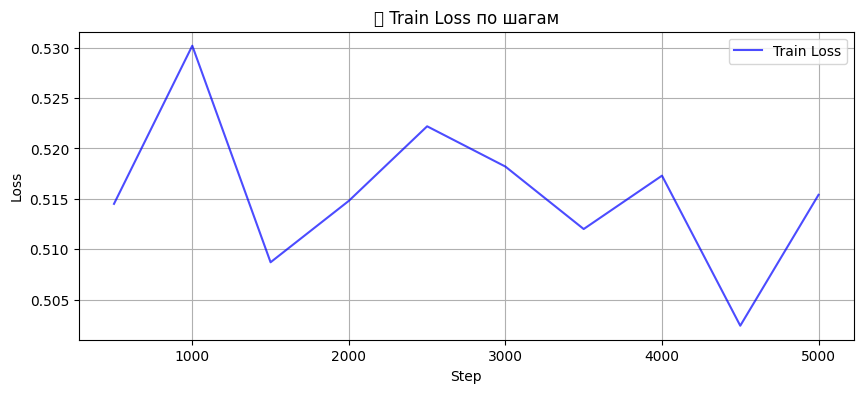

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Преобразуем логи в датафрейм
log_history = trainer.state.log_history
df = pd.DataFrame(log_history)

# --- График 1: Train Loss по шагам ---
train_loss_df = df[df['loss'].notnull()]
plt.figure(figsize=(10, 4))
plt.plot(train_loss_df['step'], train_loss_df['loss'], label="Train Loss", color="blue", alpha=0.7)
plt.title("📉 Train Loss по шагам")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()


### 📉 Поведение Train Loss по шагам

На графике нет выраженного нисходящего тренда. Loss остаётся в диапазоне 0.502–0.530. Это ожидаемо по следующим причинам:

- Используется **LoRA-адаптация**, которая обновляет только небольшую часть весов, поэтому обучение идёт медленно и мягко. Это позволяет модели адаптироваться к стилю, не разрушая имеющиеся знания.
- Обучение проведено **всего за одну эпоху**, и каждый пример из датасета видится моделью лишь один раз. Учитывая, что датасет небольшой, сильного изменения loss за одну эпоху не происходит.
- **Предобученная модель уже хорошо предсказывает ответы** в стиле инструкций. Поэтому loss изначально невысокий, и падение ограничено "потолком адекватности".


<ipython-input-22-05af5f7d9074>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_loss_df["smoothed_loss"] = train_loss_df["loss"].rolling(window=window_size).mean()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


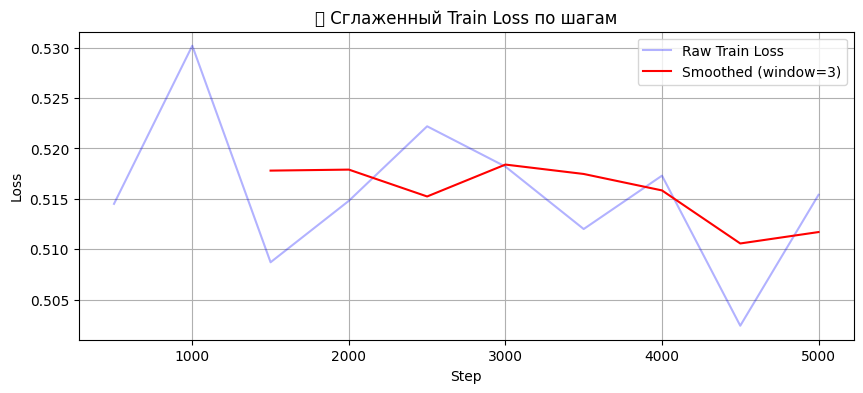

In [22]:
# Добавим сглаживание — скользящее среднее
window_size = 3
train_loss_df["smoothed_loss"] = train_loss_df["loss"].rolling(window=window_size).mean()

plt.figure(figsize=(10, 4))
plt.plot(train_loss_df["step"], train_loss_df["loss"], label="Raw Train Loss", color="blue", alpha=0.3)
plt.plot(train_loss_df["step"], train_loss_df["smoothed_loss"], label=f"Smoothed (window={window_size})", color="red")
plt.title("📉 Сглаженный Train Loss по шагам")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

### 📈 Сглаженный Train Loss: слабый, но стабильный тренд

Скользящее среднее показывает лёгкое снижение после шага 3000. Это сигнал, что адаптация всё-таки происходит, несмотря на внешне "плоский" график.

Причины такого поведения:

- После первых итераций модель "осваивается" с новыми паттернами, и ближе к концу обучения выдаёт более уверенные предсказания, что и отражается в сглаженном тренде.
- Колебания минимальны — это указывает на то, что обучение устойчиво, без резких скачков. Это особенно важно при генеративной задаче, где overshooting может испортить стиль генерации.


In [ ]:
# Сохранение модели
model.save_pretrained("./openllama3b-v2-lora-house_v1_ext")
tokenizer.save_pretrained("./openllama3b-v2-lora-house_v1_ext")

print("✅ Модель обучена и сохранена.")


In [36]:
from huggingface_hub import notebook_login

# Authenticate Hugging Face Hub
notebook_login()

# Upload to Hugging Face Hub
repo_name = "nikatonika/open_llama_3b_v2-v3_ext"
model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

print(f"✅ Model uploaded to Hugging Face Hub: https://huggingface.co/{repo_name}")

adapter_model.safetensors:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/512k [00:00<?, ?B/s]

✅ Model uploaded to Hugging Face Hub: https://huggingface.co/nikatonika/openllama3b-v2-lora-house_v1_ext
